실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

# STEP 0. 데이터 불러오기

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')   # txt파일이므로 csv처럼 콤마로 구분되어 있지 않다. 그래서 구분자를 따로 넣어줘서 구분하여 분리함
print('전체 샘플의 수 :',len(lines))
lines.sample(5)                                                        # 샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
65360,I'm tired of doing this.,Je suis fatiguée de faire ceci.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
152984,What do you have planned for tonight?,Qu'avez-vous prévu de faire pour ce soir?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
56529,I don't play that game.,Je ne joue pas à ce jeu.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
15622,She's Brazilian.,Elle est brésilienne.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
156574,This is the picture that Mary painted.,C'est le tableau que Mary a peint.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
lines = lines[['eng', 'fra']][:33000]         # 33,000 만개 샘플 사용
# lines = lines[['eng', 'fra']].sample(33000)        # 33,000 만개 샘플 사용


lines

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
...,...,...
32995,We all cried a lot.,Nous avons toutes beaucoup pleuré.
32996,We all felt hungry.,Nous avions tous faim.
32997,We also found this.,Nous avons aussi trouvé ceci.
32998,We are busy people.,Nous sommes des gens occupés.


# STEP 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

글자 단위가 아닌 **단어 단위**의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

### 1. 구두점(Punctuation)을 단어와 분리해주세요.

일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요. 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.

예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면

['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로

좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.

!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다.

이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!

분리 후 : he is a Good boy !

### 2. 소문자로 바꿔주세요.

기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !

변환 후 : he is a good boy !

### 3. 띄어쓰기 단위로 토큰를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'

토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [4]:
sos_token = '<start> '
eos_token = ' <end>'

def preprocess_sentence(line, is_target_dataset=False):
    # 소문자로 변경
    line = line.lower()
    
    # 구두점을 단어와 분리
    line = re.sub(r"([?.!,¿])", r" \1 ", line)         # 구두점이면 구두점 앞 뒤로 공백 넣기
    line = re.sub(r'[" "]+', " ", line)                # 여러 공백을 하나의 공백으로 
    line = re.sub(r"[^a-zA-Z?!.,¿']+", " ", line)    # 알파벳, 구두점이 아니면 모두 공백으로 처리
    line = line.strip()                                # 문장의 양쪽 끝 공백을 없애기
    
    if is_target_dataset is True:
        line = sos_token + line + eos_token
        
    return line

In [5]:
# 확인용
preprocess_sentence("    I'm THERe is a good            &&&&   boy!   ")

"i'm there is a good boy !"

In [6]:
# 영어, 프랑스어 전처리하기
eng_lines = []
fra_lines = []

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue   
        
    eng_lines.append(preprocess_sentence(eng))
    fra_lines.append(preprocess_sentence(fra, is_target_dataset=True))

In [7]:
# # 확인용
# fra_lines

In [8]:
# # 확인용
# eng_lines

# STEP 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

글자 단위 번역기를 구현할 때와 마찬가지로 
- 디코더의 입력 시퀀스 맨 앞에는 **시작을 의미하는 토큰**이 필요합니다. 
- 그리고 교사 강요를 수행할 때, 디코더의 실제값(Target)이 되는 디코더의 레이블 시퀀스에는 **종료를 의미하는 종료 토큰**이 필요합니다.

예를 들어 번역 문장이 Courez!이었다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['', 'courez', '!']

레이블 시퀀스 : ['courez', '!', ']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!

Step 1을 수행하는 중간에 수행해도 상관없습니다.

### -> STEP 1에서 완료함

# STEP 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은

아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.

- [위키독스](https://wikidocs.net/31766)

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

In [9]:
# 영어사전
eng_tokenizer = Tokenizer(char_level=False, filters='')                 # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(eng_lines)                       # 영어사전 만들기
                                                            # 33000개의 행을 가진 eng의 각 행에 토큰화와 인덱스 부여
input_text = eng_tokenizer.texts_to_sequences(eng_lines)    # 문장을 문자의 인덱스로 나열
input_text[:10]

[[25, 1],
 [25, 1],
 [25, 1],
 [25, 1],
 [782, 1],
 [782, 1],
 [207, 20],
 [207, 20],
 [207, 20],
 [207, 20]]

In [10]:
# 확인용
# eng_tokenizer.word_index

In [11]:
# 프랑스 사전
fra_tokenizer = Tokenizer(char_level=False, filters='')                   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(fra_lines)                         # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(fra_lines)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 70, 7, 2],
 [1, 384, 3, 2],
 [1, 26, 541, 7, 2],
 [1, 754, 7, 2],
 [1, 789, 7, 2],
 [1, 789, 3, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2]]

In [12]:
# 확인용
# fra_tokenizer.word_index

### 단어장 크기 변수로 저장
단어장의 크기를 변수로 저장해줍니다. 0번 토큰을 고려하여 +1을 하고 저장해줍니다.

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972


### 영어/프랑스 문장 최대 길이 구하기

- 이제 영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해보겠습니다. 
- 이는 패딩(<pad>)을 위함입니다. 
- 모델에 입력될 영어, 프랑스어 시퀀스의 길이가 일정해야 하므로, 최대 길이로 맞추고 남는 시퀀스 뒷부분을 패딩으로 채우게 됩니다.


In [14]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


### 지금까지 통계량 요약
전체적인 통계 정보를 정리하여 한꺼번에 출력해봅시다.

In [15]:
print('전체 샘플의 수 :',len(lines))
print('\n영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('\n영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


### Target Data의  디코더에서 2가지 버전

인코더의 입력으로 사용되는 영어 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비해야 합니다. 
- 하나는 **디코더의 출력과 비교해야 할 정답 데이터**로 사용해야 할 원래 목적에 따른 것입니다.
- 다른 하나는 **교사 강요(Teacher forcing)을 위해 디코더의 입력**으로 사용하기 위한 것입니다.
    - 이때, 디코더의 입력으로 사용할 시퀀스는 < eos >토큰이 필요가 없고, 
    - 디코더의 출력과 비교할 시퀀스는 < sos >가 필요가 없기 때문입니다. 

가령, 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 훈련 과정에서 디코더는 '< sos > Je suis une personne'를 입력받아서 'Je suis une personne < eos >'를 예측하도록 훈련되므로, 이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 합니다.

In [16]:
# English
encoder_input = input_text


# Franch
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['<end>']] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['<start>']] for line in target_text]


print(decoder_input[:3])
print(decoder_target[:3])

[[1, 70, 7], [1, 384, 3], [1, 26, 541, 7]]
[[70, 7, 2], [384, 3, 2], [26, 541, 7, 2]]


In [17]:
# 확인용
fra_tokenizer.word_index['<end>']

2

### padding 추가

In [18]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [19]:
# 확인용
print(encoder_input[100])

[67  8  3  0  0  0  0  0]


### Validation/Test DataSet

마지막으로, 훈련과정의 validation을 위해 위에서 생성한 데이터 50000건 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 삼겠습니다.

In [20]:
num_val = 3000

encoder_input_train = encoder_input[:-num_val]
decoder_input_train = decoder_input[:-num_val]
decoder_target_train = decoder_target[:-num_val]

encoder_input_test = encoder_input[-num_val:]
decoder_input_test = decoder_input[-num_val:]
decoder_target_test = decoder_target[-num_val:]

print('영어 학습데이터의 크기(shape) :', np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :', np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :', np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 16)


# Step 4. 임베딩 층(Embedding layer) 사용하기

이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.

임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의

1. 케라스 임베딩 층(Keras Embedding layer) 를 참고하세요.

- [위키독스](https://wikidocs.net/33793)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다.

이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

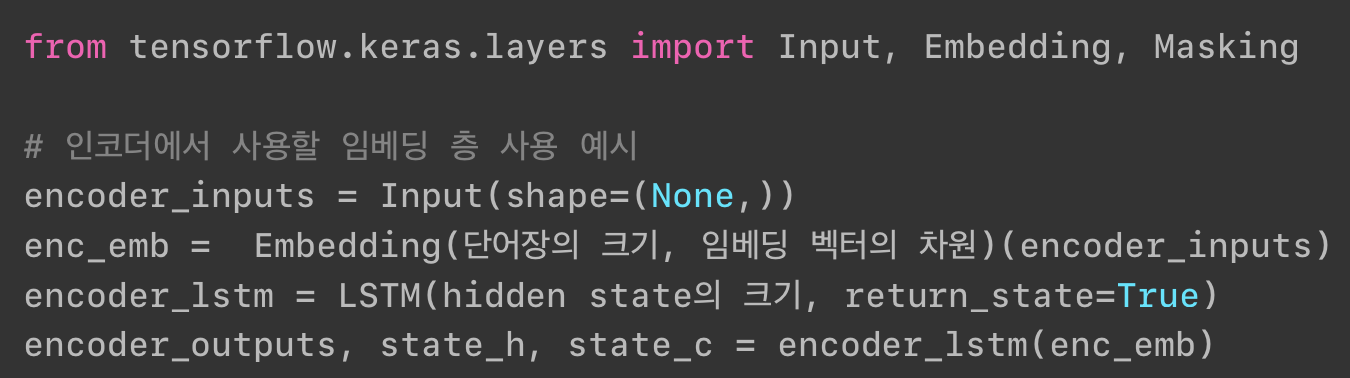

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,

디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!


### 인코더 입력층 설계

In [21]:
embedding_size = 128
hidden_size = 128

encoder_inputs = Input(shape=(None,))                                # 'None' elements represent dimensions where the shape is not known.
enc_emb = Embedding(eng_vocab_size, embedding_size)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)                       # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outpus, state_h, state_c = encoder_lstm(enc_masking)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

### 디코더 입력층 설계

In [22]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, ))                            # 'None' elements represent dimensions where the shape is not known.
dec_emb_layer = Embedding(fra_vocab_size, embedding_size)
dec_emb = dec_emb_layer(decoder_inputs)    
dec_masking = Masking(mask_value=0.0)(dec_emb)                                     # 패딩 0은 연산에서 제외

decoder_lstm = LSTM(hidden_size, dropout=0.3, return_sequences = True, return_state=True)       # hidden size가 256인 인코더의 LSTM 셀 생성

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)  # initial_state 추가됨


세번째 줄을 보면 디코더의 인자로 initial_state가 추가되었는데요. LSTM 셀의 초기 상태를 정의해줄 수 있는 인자입니다. 여기서는 이전에 저장한 인코더의 마지막 time step의 hidden state와 cell state를 사용하였습니다. 디코더의 출력층을 설계해줍니다.

In [23]:
# 확인용
decoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_2')>

In [24]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [25]:
# 확인용
decoder_outputs

<KerasTensor: shape=(None, None, 7972) dtype=float32 (created by layer 'dense')>

### 인코더와 디코더 연결
최종적으로 인코더와 디코더를 연결해서 하나의 모델로 만들어줍니다.  
Model의 Input과 Output의 정의를 유심히 살펴 주세요.

In [26]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    610688      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1020416     input_2[0][0]                    
______________________________________________________________________________________________

### 모델 학습

In [27]:
history = model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=60, 
          epochs=50)

Epoch 1/50
500/500 [==============================] - 17s 22ms/step - loss: 1.8637 - acc: 0.7239 - val_loss: 1.8146 - val_acc: 0.7322
Epoch 2/50
500/500 [==============================] - 9s 18ms/step - loss: 1.3883 - acc: 0.7817 - val_loss: 1.6202 - val_acc: 0.7547
Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 1.2323 - acc: 0.8060 - val_loss: 1.5205 - val_acc: 0.7727
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 1.1398 - acc: 0.8189 - val_loss: 1.4409 - val_acc: 0.7830
Epoch 5/50
500/500 [==============================] - 9s 18ms/step - loss: 1.0737 - acc: 0.8285 - val_loss: 1.3948 - val_acc: 0.7903
Epoch 6/50
500/500 [==============================] - 9s 18ms/step - loss: 1.0190 - acc: 0.8354 - val_loss: 1.3537 - val_acc: 0.7944
Epoch 7/50
500/500 [==============================] - 9s 18ms/step - loss: 0.9756 - acc: 0.8408 - val_loss: 1.3289 - val_acc: 0.7981
Epoch 8/50
500/500 [==============================] - 9s 18ms/step -

### 시각화

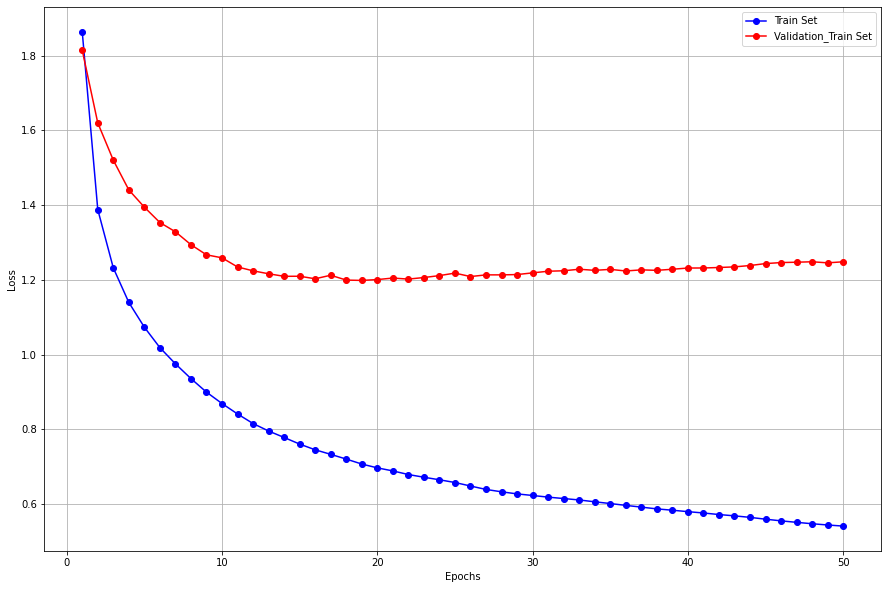

In [28]:
# Train 데이터셋의 학습 결과
# Loss 확인
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']


epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15, 10))

plt.plot(epochs, loss, c='b', marker='o', label="Train Set")
plt.plot(epochs, val_loss, c='r', marker='o', label="Validation_Train Set")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

<Figure size 432x288 with 0 Axes>

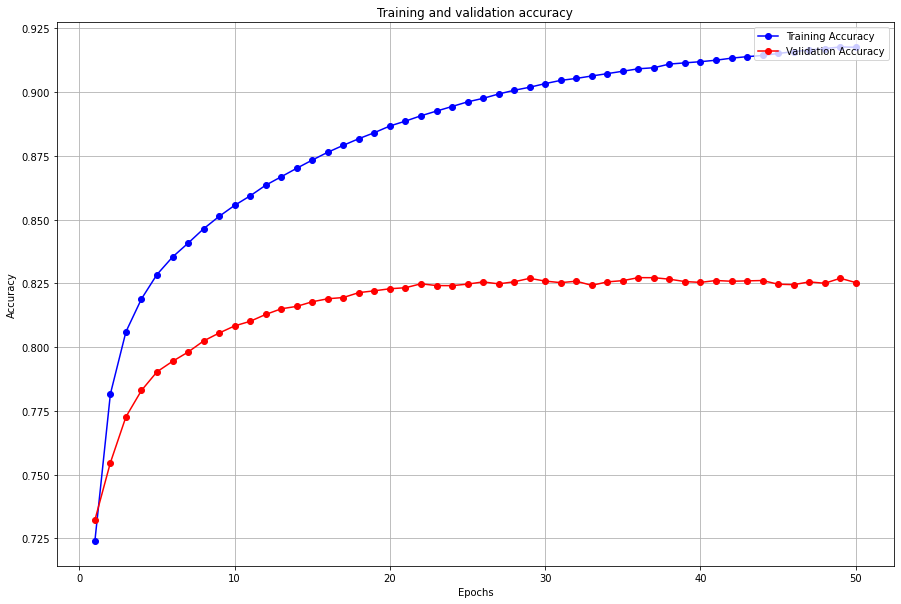

In [29]:
# Accuracy 확인
plt.clf()                                   # 그림을 초기화함


plt.figure(figsize=(15, 10))

plt.plot(epochs, acc, c='b', marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc,c='r', marker='o', label='Validation Accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [30]:
# 확인용
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

# STEP 5. 모델 구현하기

글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!

# STEP 6. 모델 평가하기

단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요.

모델 평가를 진행할때 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 프로젝트는 단어 단위에서 구현되는 번역기입니다.

Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.

decode sentence를 구성할때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.

## 테스트를 위해 모델 재설계

우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 이미 정의한 것들을 재사용합니다.

In [31]:
# 인코더 재설계
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)   # encoder_states는 위에서 이미 학습한 hidden state, cell state 임
                                                                           # The input(s) of the model: a keras.Input object or list of keras.Input objects.
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         610688    
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 131584    
Total params: 742,272
Trainable params: 742,272
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 디코더 재설계
# 이전 time step의 상태를 보관/저장할 텐서
decoder_state_input_h = Input(shape=(hidden_size,))           # 이전 hidden state, 
decoder_state_input_c = Input(shape=(hidden_size,))           # 이전 cell state
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]  # 이전 time step의 hidden state와 cell state를 하나의 변수에 저장


# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)


# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]


# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

# 디코더 모델
# 입력 3개 - hidden state + cell state + decoder_input 
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, 
                      outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    1020416     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary)을 준비해 둡니다. 테스트 결과를 해석하기 위해선 다시 사전이 필요하겠죠? 우리는 이전 스텝에서 문장을 숫자 인덱스로 바꾸는 Tokenizer를 만들면서 자동으로 만들어진 사전을 이미 가지고 있습니다.

디코더의 출력층을 재설계해줍니다.


In [33]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

### decode_sequence() 함수 구조
이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다.   

decode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다.  
함수 decode_sequence() 내부에는 인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면, encoder_model은 마지막 시점의 hidden state를 리턴합니다.

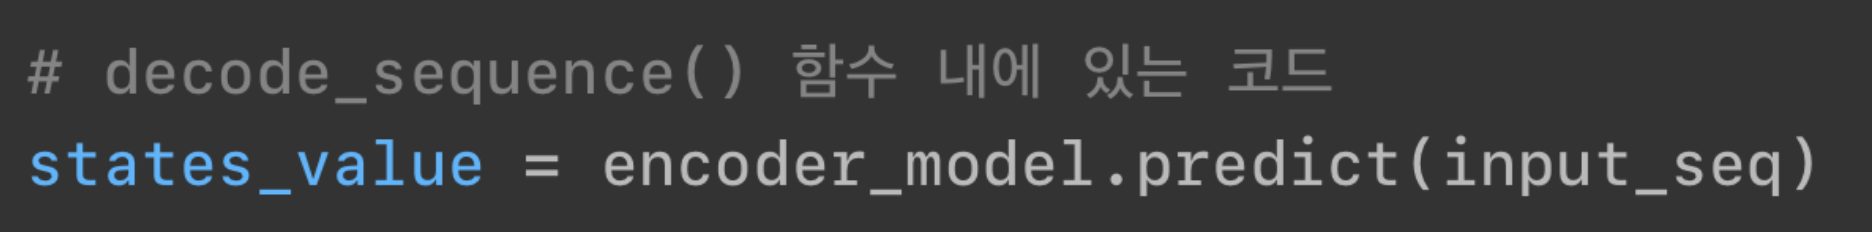

이 hidden state는 디코더의 첫번째 시점의 hidden state가 되고, 디코더는 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다. 디코더의 예측 과정에서는 이전 시점에서 예측한 단어를 디코더의 현재 시점의 입력으로 넣어주는 작업을 진행합니다. 그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나, 주어진 최대 길이를 넘을 때까지 반복합니다.

In [34]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 정수 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <end>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

이렇게 구현한 함수를 임의의 인덱스의 번역하고자하는 문장 샘플을 입력하여,

출력 결과를 테스트해보겠습니다.

In [35]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i != 0):
            temp = temp + idx2eng[i]+' '
    return temp

In [36]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [37]:
for seq_index in [1,250,431,105,322]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: i lost your number . 
정답 문장: j'ai perdu votre num ro . 
번역기가 번역한 문장:  j'ai est ton le l
-----------------------------------
입력 문장: i think you did it . 
정답 문장: je pense que c'est toi qui l'a fait . 
번역기가 번역한 문장:  je sais l'a vou
-----------------------------------
입력 문장: i won't say a word . 
정답 문장: je ne dirai pas un mot . 
번역기가 번역한 문장:  je ne ne de de d
-----------------------------------
입력 문장: i never was skinny . 
정답 문장: je n'ai jamais t maigre . 
번역기가 번역한 문장:  je ne ne pas jamai
-----------------------------------
입력 문장: i want to tell you . 
정답 문장: je veux vous le dire . 
번역기가 번역한 문장:  je pouvez te me m


입력 문장: i lost your number -> 수를 잃어버렸다  
정답 문장: j'ai perdu votre num ro . -> 나는 당신의 번호를 잃어 버렸습니다  
번역기가 번역한 문장:  j'ai est ton le l -> 나는 당신의 l입니다
    
입력 문장: i think you did it . -> 나는 당신이 했다고 생각합니다  
정답 문장: je pense que c'est toi qui l'a fait . -> 당신이 한 것 같아요  
번역기가 번역한 문장:  je sais l'a vou -> 나는 당신을 알고

입력 문장: i won't say a word . -> 나는 한 마디도 하지 않을 것이다  
정답 문장: je ne dirai pas un mot . -> 아무 말도 하지 않겠어  
번역기가 번역한 문장:  je ne ne de de d -> 나는 d의  

입력 문장: i never was skinny . -> 나는 결코 마른 적이 없었다  
정답 문장: je n'ai jamais t maigre . -> 나는 마른 적이 없다  
번역기가 번역한 문장:  je ne ne pas jamai -> 난 절대  

입력 문장: i want to tell you . -> 나는 당신에게 말하고 싶다  
정답 문장: je veux vous le dire . -> 나는 당신에게 말하고 싶다  
번역기가 번역한 문장:  je pouvez te me m -> 난 너에게 말할 수있어  

# STEP 7. 회고

1. 이번 프로젝트에서 어려웠던 점
    - 코드를 이해하는게 어려웠다
    - 각 층의 입력값을 어떻게 설정하는게 어려웠다
    - 테스트용 디코더 설계시 코드를 구현하는게 어려웠다

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 각 층의 입력값을 정확히 어떻게 넣어야할지 모르겠다
    - 번역 결과가 좋지 않아서 옵티마이저와 하이퍼파라미터를 변경하면서 시도하였으나 만족할만한 결과를 얻지 못했다


3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - 전처리 함수정의하여 해결
    - 그래프 표현하고 validation loss를 줄였음
    - 프랑스어로 변역하였고 어느정도 유의미한 문장을 도출함

4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정
    - 달성함
5. 자기 다짐
    - seq2seq의 핵심 의미는 이해하기 쉬웠으나 이를 코드로 구현하는 것이 어려웠다. 코드를 빠르게 읽고 이해하며 명확히 구현할 수 있도록 많은 자료를 찾아봐야겠다

# 시도 기록

1. 10차 시도 - 12 epochs, embedding_size = 1024, hidden_size = 526, dropout = 0.3, 번역완성도 60%
2. 11차 시도 - 12 epochs, embedding_size = 1024, hidden_size = 50, dropout = 0.3, 번역완성도 30%
3. 12차 시도 - 29 epochs, embedding_size = 1024, hidden_size = 50, dropout = 0.3, 번역완성도 30%
4. 13차 시도 - 29 epochs, embedding_size = 1024, hidden_size = 1024, dropout = 0.3, 번역완성도 50%
5. 14차 시도 - 